In [ ]:
!pip install contractions

In [ ]:
!pip install transformers datasets

In [3]:
import nltk
nltk.download('punkt_tab')

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Load Data and EDA

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/My Drive/code/Tweet/train.csv', encoding='latin-1')
test = pd.read_csv('/content/drive/My Drive/code/Tweet/test.csv', encoding='latin-1')

In [6]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [7]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

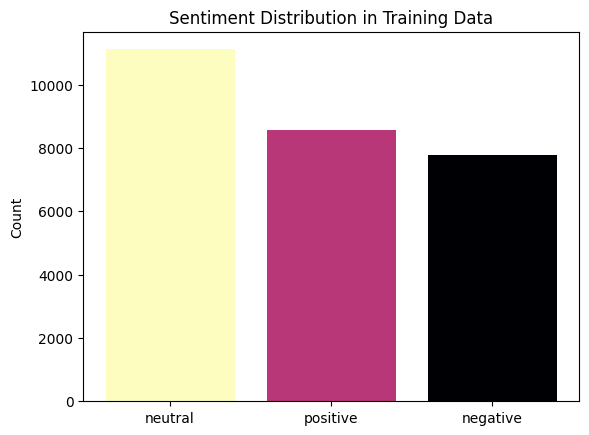

In [8]:
sentiment_counts = train['sentiment'].value_counts()

ranks = np.argsort(np.argsort(sentiment_counts.values))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.ylabel("Count")
plt.title("Sentiment Distribution in Training Data")
plt.show()

Use only text and sentiment columns

In [9]:
col = ['text', 'sentiment']

train_df = train[col]
test_df = test[col]

## Prepare Sentiment Labels

In [10]:
sentiment_to_index = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
  }

train_df.loc[:, 'sentiment'] = train_df['sentiment'].map(sentiment_to_index)
test_df.loc[:, 'sentiment'] = test_df['sentiment'].map(sentiment_to_index)

train_df.columns = ['texts', 'labels']
test_df.columns = ['texts', 'labels']

In [11]:
train_df.head()

,texts,labels
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


## Prepare Text Data

### Adjust Words based on REGEX

In [12]:
def remove_special_character(text):
    text=re.sub('<.*?>', ' ', text)
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    text = re.sub('`', "'",  text)
    # Keep apostrophes only if inside words (like "I'm", "don't")
    text = re.sub(r"[^\w\s']", '', text)
    return text

In [13]:
import contractions

# couldn't -> could not
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [14]:
train_df.loc[:, 'texts'] = train_df['texts'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)
test_df.loc[:, 'texts'] = test_df['texts'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)

In [15]:
train_df.head()

,texts,labels
0,i would have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,sons of why could not they put them on the re...,0


### Convert to Dataset

In [16]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

## Data Prediction
### Initialize BERT Mini Model and Tokenizer from HuggingFace

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-mini', num_labels=3)
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-mini')

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

In [27]:
def tokenize_function(examples):
    return tokenizer(examples["texts"], padding="max_length", truncation=True, max_length=128)

train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [35]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-1

In [34]:
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir='/content/drive/My Drive/code/Tweet/output',
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    gradient_accumulation_steps=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [29]:
print(train_dataset[0])

{'texts': 'i would have responded if i were going', 'labels': 1, '__index_level_0__': 0}


In [30]:
trainer = Trainer(
	model = model,
	args = training_args,
	train_dataset=train_tokenized,
	eval_dataset=test_tokenized
)
trainer.train()

Epoch,Training Loss,Validation Loss
0,0.662300,0.623822


TrainOutput(global_step=1717, training_loss=0.7057939400559049, metrics={'train_runtime': 2242.7092, 'train_samples_per_second': 12.253, 'train_steps_per_second': 0.766, 'total_flos': 68066174423040.0, 'train_loss': 0.7057939400559049, 'epoch': 0.9997088791848617})

In [36]:
log_history = trainer.state.log_history

for log in log_history:
    print(log)

{'loss': 1.0196, 'grad_norm': 6.286263942718506, 'learning_rate': 4.7087944088526504e-05, 'epoch': 0.05822416302765648, 'step': 100}
{'loss': 0.8221, 'grad_norm': 5.5845441818237305, 'learning_rate': 4.4175888177053005e-05, 'epoch': 0.11644832605531295, 'step': 200}
{'loss': 0.7385, 'grad_norm': 7.818515777587891, 'learning_rate': 4.12638322655795e-05, 'epoch': 0.17467248908296942, 'step': 300}
{'loss': 0.7267, 'grad_norm': 7.1406707763671875, 'learning_rate': 3.8351776354106e-05, 'epoch': 0.2328966521106259, 'step': 400}
{'loss': 0.7252, 'grad_norm': 8.561589241027832, 'learning_rate': 3.54397204426325e-05, 'epoch': 0.29112081513828236, 'step': 500}
{'loss': 0.6926, 'grad_norm': 4.156740665435791, 'learning_rate': 3.2527664531159005e-05, 'epoch': 0.34934497816593885, 'step': 600}
{'loss': 0.6551, 'grad_norm': 5.7972822189331055, 'learning_rate': 2.9615608619685496e-05, 'epoch': 0.40756914119359533, 'step': 700}
{'loss': 0.6606, 'grad_norm': 6.62971830368042, 'learning_rate': 2.6703552

### Evaluation

In [31]:
trainer.evaluate()

{'eval_loss': 0.6238223910331726,
 'eval_runtime': 119.2398,
 'eval_samples_per_second': 29.638,
 'eval_steps_per_second': 7.414,
 'epoch': 0.9997088791848617}

In [32]:
class_names = ['Negative', 'Neutral', 'Positive']
predictions = trainer.predict(test_tokenized)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids  # True labels

report = classification_report(labels, preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      1001
     Neutral       0.71      0.68      0.70      1430
    Positive       0.81      0.77      0.79      1103

    accuracy                           0.74      3534
   macro avg       0.74      0.74      0.74      3534
weighted avg       0.74      0.74      0.74      3534



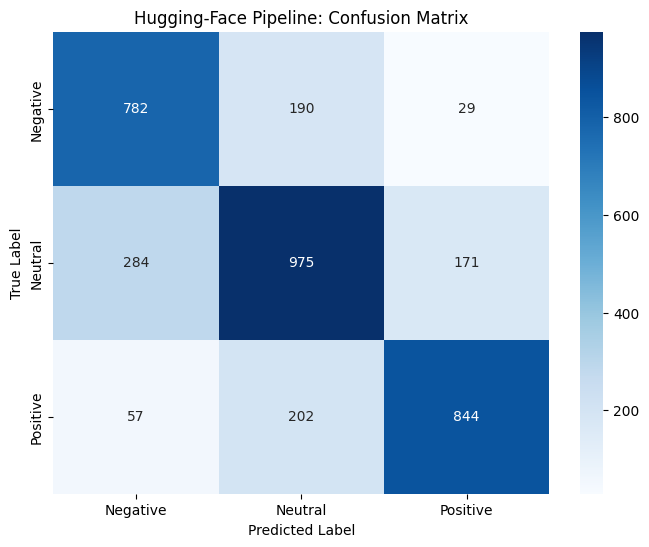

In [33]:
cm = confusion_matrix(labels, preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Hugging-Face Pipeline: Confusion Matrix")
plt.show()